In [1]:
# coding: utf-8
# Our base common modules
from Common.UtilFuncs import Evaluator, Lab

# Classifiers without denoising
import Common.SvmMethod as SvmMethod

# Denoising Methodes
import Common.IsolationForestMethod as IsolationForestMethod
import Common.ConfidentLearningMethod as ConfidentLearningMethod
import Common.LocalOutlierFactorMethod as LocalOutlierFactorMethod
from Common.BERTModel import do_experiment_BERT, BERTModel

In [2]:
# The settings of the noise sources.
# Each item: source -> (size, distribution)
noisy_set_sizes0 = {
    'mislabeled' : (7600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    # 'translated' : (8600, "reserve_labels"),       # max size: 5000
}

noisy_set_sizes1 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    # 'translated' : (8600, "reserve_labels"),       # max size: 5000
}

noisy_set_sizes2 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 0),       # max size: 5000
}

noisy_set_sizes3 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 0.50),                   # max size: 5000
}

noisy_set_sizes4 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 1),                   # max size: 5000
}

# Choose a experiment without denoising
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_without_denoising = {
    'SVM' : (SvmMethod.do_experiment, 0),
    'BERT' : (do_experiment_BERT, None, 1),
}

# Choose a experiment with denoising
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
# experiment_with_denoising = {
#     'Confident Learning' : (do_experiment_denoised_by_ConfidentLearning, 1),
#     'Isolation Forest'   : (do_experiment_denoised_by_IsolationForest,   0),
# }

# The training set of each experiment
origin_train_set_sizes_part1 = [2000, 4000, 5000, 8000]
origin_train_set_sizes_part2 = [ 10000, 15000, 20000]
#origin_train_set_sizes = [15000]
# origin_train_set_sizes = [5000, 10000, 15000, 20000]
noisy_train_set_sizes  = [(4000, 1000), (8000, 2000), (12000,3000), (15000, 5000)]
#noisy_train_set_sizes  = [(12000, 3000)]

In [3]:
RUN = 1      #1/0:  Run new experiments / Read results made by previous experiments

if RUN:
    # Run new experiments
    # Initialize the lab, which will run a serial of experiments
    lab = Lab("twitter_sentiment_data_clean.csv", noisy_sources = noisy_set_sizes0, total_train_size = 20000, total_test_size = 4000, validation_size=2000)
    experiment_without_denoising['BERT'] = (do_experiment_BERT, lab.dc.get_validation_df(), 1)
    lab.set_experiment_no_denoising(experiment_without_denoising)

* 1> Training set size: 2000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/2000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs\

Epoch 1/50


125/125 [==============================] - 75s 555ms/step - loss: 1.1618 - accuracy: 0.5095 - val_loss: 0.9326 - val_accuracy: 0.6050 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.6040
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
125/125 [==============================] - 68s 543ms/step - loss: 0.9405 - accuracy: 0.6040 - val_loss: 0.9838 - val_accuracy: 0.6140 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 69s 551ms/step - loss: 0.5784 - accuracy: 0.7630 - val_loss: 0.8215 - val_accuracy: 0.6710 - lr: 1.0000e-05
Epoch 4/50
125/125 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8195
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
125/125 [==============================] - 83s 668ms/step - loss: 0.4544 - accuracy: 0.8195 - val_loss: 0.8464 - val_accuracy: 0.6650 - lr: 1.0000e-05
Epoch 5/50
125/125 [==============================] - 69s

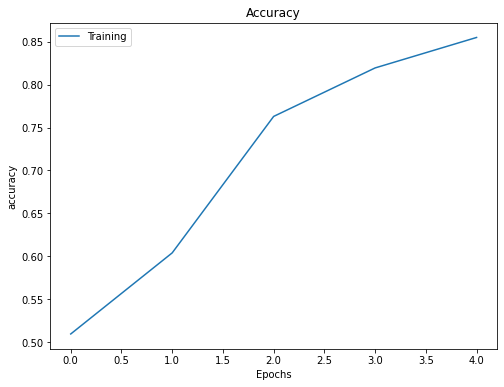

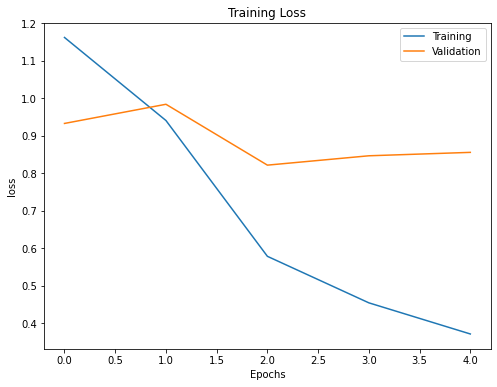

INFO:tensorflow:Assets written to: ram://47fc47fb-f424-443d-bd66-55193718d60a/assets


INFO:tensorflow:Assets written to: ram://47fc47fb-f424-443d-bd66-55193718d60a/assets


* 2> Training set size: 4000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/4000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs\

Epoch 1/50
250/250 [==============================] - 134s 486ms/step - loss: 1.0655 - accuracy: 0.5615 - val_loss: 0.9677 - val_accuracy: 0.6045 - lr: 1.0000e-04
Epoch 2/50
250/250 [==============================] - 117s 469ms/step - loss: 0.8388 - accuracy: 0.6720 - val_loss: 0.7970 - val_accuracy: 0.6895 - lr: 1.0000e-04
Epoch 3/50
250/250 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7983
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
250/250 [==============================] - 116s 463ms/step - loss: 0.5481 - accuracy: 0.7983 - val_loss: 0.9960 - val_accuracy: 0.6430 - lr: 1.0000e-04
Epoch 4/50
250/250 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9283
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
250/250 [==============================] - 117s 469ms/step - loss: 0.1978 - accuracy: 0.9283 - val_loss: 1.0018 - val_accuracy: 0.7070 - lr: 1.0000e-05
Epoch 4: early stopping
    f1 of classes:

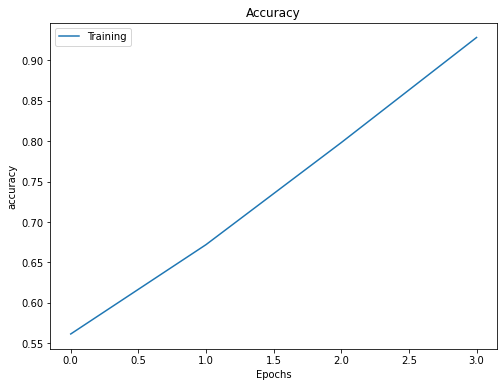

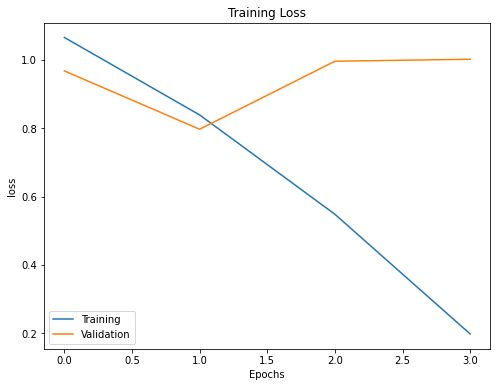

INFO:tensorflow:Assets written to: ram://b7c80191-b030-4076-9c97-de00471e760d/assets


INFO:tensorflow:Assets written to: ram://b7c80191-b030-4076-9c97-de00471e760d/assets


* 3> Training set size: 5000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/5000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs\

Epoch 1/50
313/313 [==============================] - 154s 466ms/step - loss: 1.0480 - accuracy: 0.5644 - val_loss: 0.8875 - val_accuracy: 0.6480 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - 145s 461ms/step - loss: 0.8038 - accuracy: 0.6892 - val_loss: 0.8339 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.8136
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
313/313 [==============================] - 143s 458ms/step - loss: 0.4996 - accuracy: 0.8136 - val_loss: 0.9594 - val_accuracy: 0.6950 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9442
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
313/313 [==============================] - 145s 462ms/step - loss: 0.1458 - accuracy: 0.9442 - val_loss: 1.1564 - val_accuracy: 0.7135 - lr: 1.0000e-05
Epoch 4: early stopping
    f1 of classes:

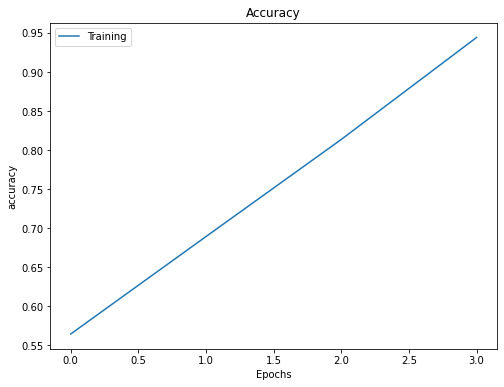

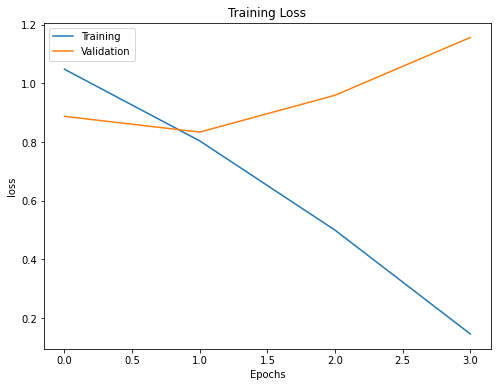

INFO:tensorflow:Assets written to: ram://3ed9aef0-f38e-467b-8de7-e00515cf2f7e/assets


INFO:tensorflow:Assets written to: ram://3ed9aef0-f38e-467b-8de7-e00515cf2f7e/assets


* 4> Training set size: 8000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/8000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs\

Epoch 1/50


500/500 [==============================] - 225s 439ms/step - loss: 1.0116 - accuracy: 0.5909 - val_loss: 0.8370 - val_accuracy: 0.6755 - lr: 1.0000e-04
Epoch 2/50
500/500 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.7130
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
500/500 [==============================] - 218s 436ms/step - loss: 0.7522 - accuracy: 0.7130 - val_loss: 0.9897 - val_accuracy: 0.6660 - lr: 1.0000e-04
Epoch 3/50
500/500 [==============================] - 219s 439ms/step - loss: 0.3082 - accuracy: 0.8815 - val_loss: 0.8341 - val_accuracy: 0.7260 - lr: 1.0000e-05
Epoch 4/50
500/500 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9375
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
500/500 [==============================] - 220s 439ms/step - loss: 0.1757 - accuracy: 0.9375 - val_loss: 1.0681 - val_accuracy: 0.7270 - lr: 1.0000e-05
Epoch 5/50
500/500 [==============================] -

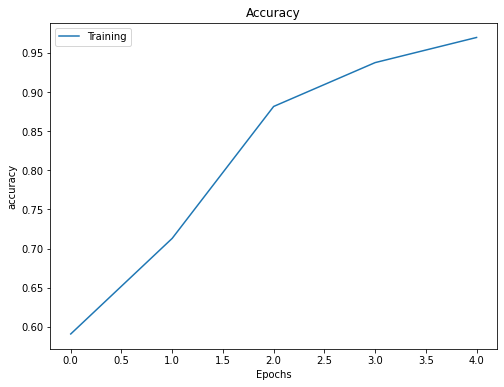

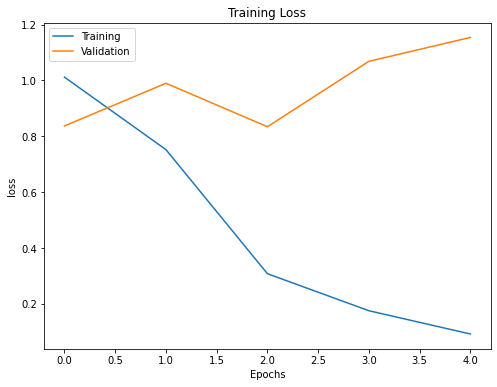

INFO:tensorflow:Assets written to: ram://db8bd67f-d0b0-4fab-8603-414adf796de8/assets


INFO:tensorflow:Assets written to: ram://db8bd67f-d0b0-4fab-8603-414adf796de8/assets


In [4]:
if RUN:    
    # Run experiment on original data
    BERTModel.HistoryFilePrefix = "OriginTrainDataPart1_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.do_batch_experiments(origin_train_set_sizes_part1)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step0.csv")

* 5> Training set size: 10000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/10000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


625/625 [==============================] - 276s 432ms/step - loss: 1.0094 - accuracy: 0.5901 - val_loss: 0.8741 - val_accuracy: 0.6885 - lr: 1.0000e-04
Epoch 2/50
625/625 [==============================] - ETA: 0s - loss: 0.7593 - accuracy: 0.7127
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
625/625 [==============================] - 268s 429ms/step - loss: 0.7593 - accuracy: 0.7127 - val_loss: 1.0314 - val_accuracy: 0.6840 - lr: 1.0000e-04
Epoch 3/50
625/625 [==============================] - 269s 431ms/step - loss: 0.3239 - accuracy: 0.8783 - val_loss: 0.8325 - val_accuracy: 0.7335 - lr: 1.0000e-05
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9309
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
625/625 [==============================] - 270s 431ms/step - loss: 0.1875 - accuracy: 0.9309 - val_loss: 0.9646 - val_accuracy: 0.7405 - lr: 1.0000e-05
Epoch 5/50
625/625 [==============================] -

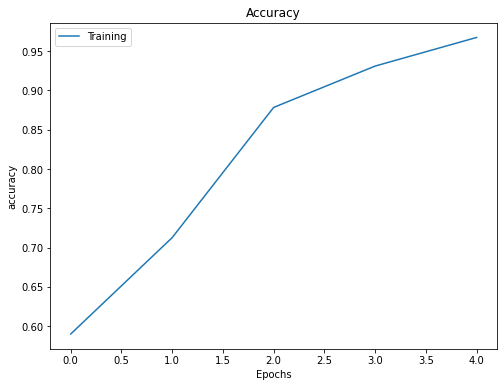

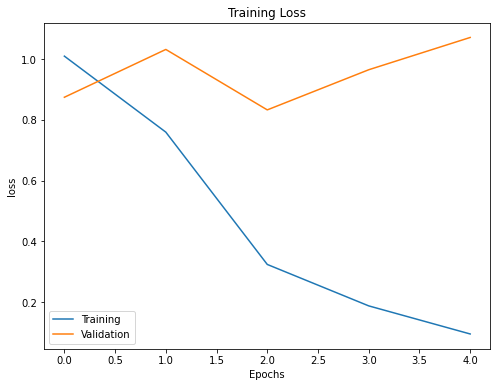

INFO:tensorflow:Assets written to: ram://b20cf7c4-abf2-4e92-9c76-bc1a230d1fda/assets


INFO:tensorflow:Assets written to: ram://b20cf7c4-abf2-4e92-9c76-bc1a230d1fda/assets


* 6> Training set size: 15000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


938/938 [==============================] - 419s 438ms/step - loss: 0.9487 - accuracy: 0.6213 - val_loss: 0.7647 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7254
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 405s 432ms/step - loss: 0.7121 - accuracy: 0.7254 - val_loss: 1.0007 - val_accuracy: 0.6725 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - 404s 431ms/step - loss: 0.3044 - accuracy: 0.8867 - val_loss: 0.7629 - val_accuracy: 0.7475 - lr: 1.0000e-05
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9379
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 404s 431ms/step - loss: 0.1745 - accuracy: 0.9379 - val_loss: 0.8628 - val_accuracy: 0.7480 - lr: 1.0000e-05
Epoch 5/50
938/938 [==============================] -

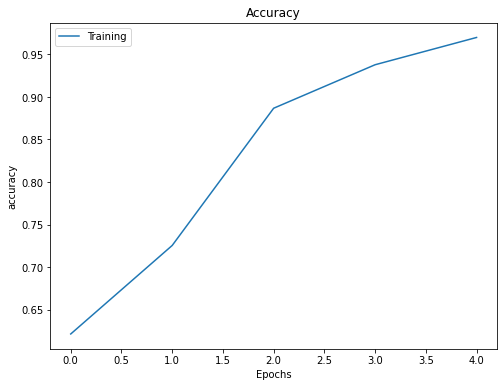

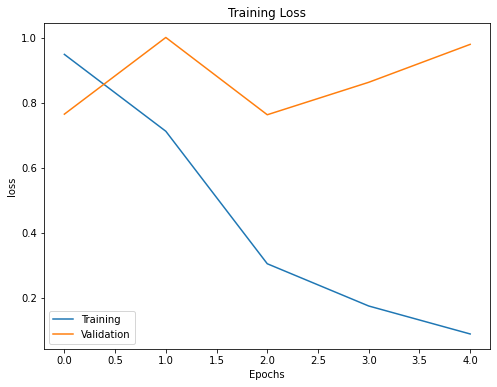

INFO:tensorflow:Assets written to: ram://c3fc0a1e-3640-4784-a2a6-421deb096e26/assets


INFO:tensorflow:Assets written to: ram://c3fc0a1e-3640-4784-a2a6-421deb096e26/assets


* 7> Training set size: 20000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/20000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


1250/1250 [==============================] - 531s 420ms/step - loss: 0.9328 - accuracy: 0.6315 - val_loss: 0.7695 - val_accuracy: 0.6990 - lr: 1.0000e-04
Epoch 2/50
1250/1250 [==============================] - 525s 420ms/step - loss: 0.7023 - accuracy: 0.7338 - val_loss: 0.7310 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 3/50
1250/1250 [==============================] - 525s 420ms/step - loss: 0.4953 - accuracy: 0.8176 - val_loss: 0.7115 - val_accuracy: 0.7505 - lr: 1.0000e-04
Epoch 4/50
1250/1250 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8781
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1250/1250 [==============================] - 524s 419ms/step - loss: 0.3362 - accuracy: 0.8781 - val_loss: 0.8686 - val_accuracy: 0.7420 - lr: 1.0000e-04
Epoch 5/50
1250/1250 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9560
Epoch 5: ReduceLROnPlateau reducing learning rate to 1e-06.
1250/1250 [===================

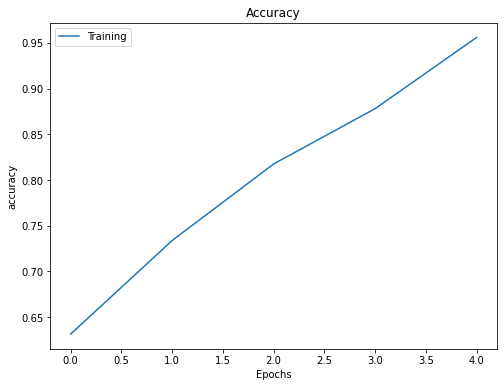

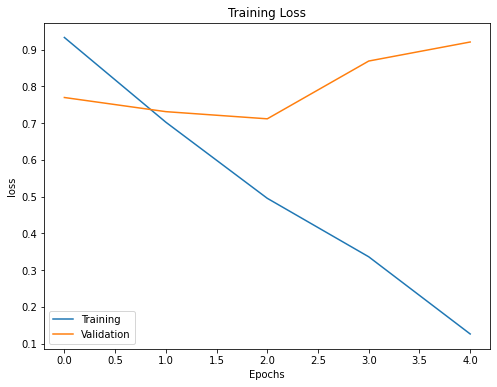

INFO:tensorflow:Assets written to: ram://94cadc20-ef13-4d9f-987c-43e450b73fa9/assets


INFO:tensorflow:Assets written to: ram://94cadc20-ef13-4d9f-987c-43e450b73fa9/assets


In [5]:
if RUN:    
    # Run experiment on original data
    BERTModel.HistoryFilePrefix = "OriginTrainDataPart2_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.do_batch_experiments(origin_train_set_sizes_part2)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step1.csv")

* 8> Noisy training set size: 5000 samples (4000 original, 1000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 13.8%, 20.1%, 43.3%, 22.7%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/5000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs\

Epoch 1/50


313/313 [==============================] - 154s 463ms/step - loss: 1.2981 - accuracy: 0.4348 - val_loss: 0.9567 - val_accuracy: 0.6150 - lr: 1.0000e-04
Epoch 2/50
313/313 [==============================] - 145s 463ms/step - loss: 1.1864 - accuracy: 0.5260 - val_loss: 0.9126 - val_accuracy: 0.6505 - lr: 1.0000e-04
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 1.0007 - accuracy: 0.6198
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
313/313 [==============================] - 143s 458ms/step - loss: 1.0007 - accuracy: 0.6198 - val_loss: 0.9834 - val_accuracy: 0.6355 - lr: 1.0000e-04
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.8384
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
313/313 [==============================] - 147s 469ms/step - loss: 0.4628 - accuracy: 0.8384 - val_loss: 0.9583 - val_accuracy: 0.6650 - lr: 1.0000e-05
Epoch 4: early stopping
    f1 of classes: [0.412, 0.

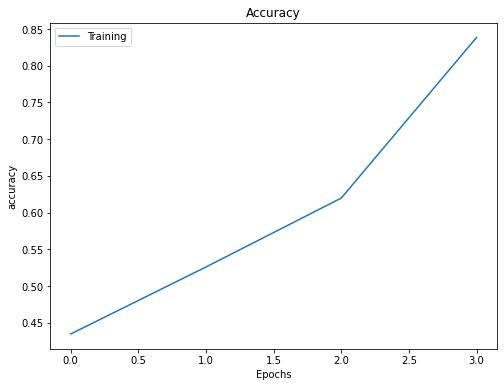

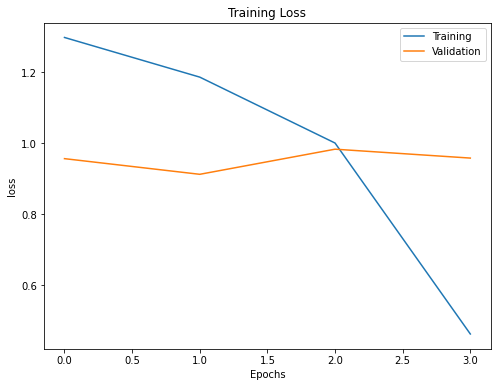

INFO:tensorflow:Assets written to: ram://2a5e265c-be26-4842-950c-a49b11f06f15/assets


INFO:tensorflow:Assets written to: ram://2a5e265c-be26-4842-950c-a49b11f06f15/assets


* 9> Noisy training set size: 10000 samples (8000 original, 2000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 13.9%, 19.9%, 43.3%, 22.9%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/10000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


625/625 [==============================] - 286s 446ms/step - loss: 1.2987 - accuracy: 0.4551 - val_loss: 0.9599 - val_accuracy: 0.6445 - lr: 1.0000e-04
Epoch 2/50
625/625 [==============================] - 320s 512ms/step - loss: 1.1964 - accuracy: 0.5295 - val_loss: 0.7990 - val_accuracy: 0.6965 - lr: 1.0000e-04
Epoch 3/50
625/625 [==============================] - ETA: 0s - loss: 1.0044 - accuracy: 0.6273
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
625/625 [==============================] - 322s 516ms/step - loss: 1.0044 - accuracy: 0.6273 - val_loss: 0.8378 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 4/50
625/625 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.8183
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
625/625 [==============================] - 320s 512ms/step - loss: 0.5170 - accuracy: 0.8183 - val_loss: 0.9126 - val_accuracy: 0.6990 - lr: 1.0000e-05
Epoch 4: early stopping
    f1 of classes: [0.445, 0.

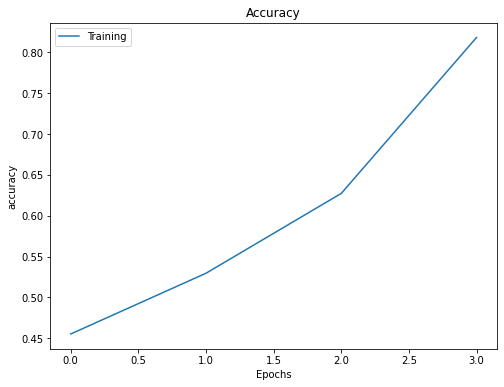

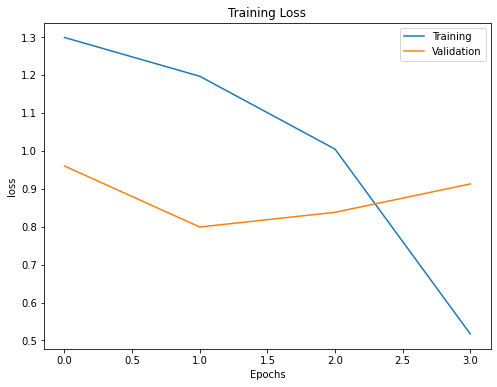

INFO:tensorflow:Assets written to: ram://e118d04d-0e81-4190-abb1-4c36591c8a64/assets


INFO:tensorflow:Assets written to: ram://e118d04d-0e81-4190-abb1-4c36591c8a64/assets


*10> Noisy training set size: 15000 samples (12000 original, 3000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 13.8%, 19.8%, 43.5%, 22.9%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


938/938 [==============================] - 422s 440ms/step - loss: 1.2843 - accuracy: 0.4726 - val_loss: 1.0589 - val_accuracy: 0.6025 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 423s 451ms/step - loss: 1.1640 - accuracy: 0.5485 - val_loss: 0.7659 - val_accuracy: 0.7140 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.9782 - accuracy: 0.6409
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 468s 499ms/step - loss: 0.9782 - accuracy: 0.6409 - val_loss: 0.8213 - val_accuracy: 0.7045 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.8149
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 516s 550ms/step - loss: 0.5430 - accuracy: 0.8149 - val_loss: 0.8605 - val_accuracy: 0.7030 - lr: 1.0000e-05
Epoch 4: early stopping
    f1 of classes: [0.289, 0.

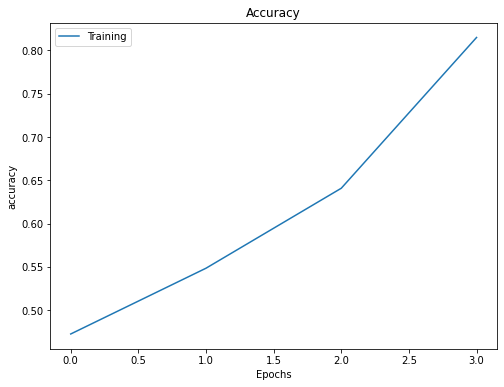

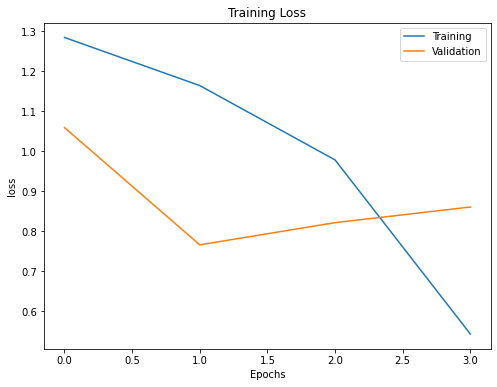

INFO:tensorflow:Assets written to: ram://dda94706-d48f-4c73-a853-d876c35b12d4/assets


INFO:tensorflow:Assets written to: ram://dda94706-d48f-4c73-a853-d876c35b12d4/assets


*11> Noisy training set size: 20000 samples (15000 original, 5000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 14.9%, 20.3%, 41.8%, 23.0%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 100.0%, 0.0%, 0.0%
  Before de-noising:


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/20000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50
1250/1250 [==============================] - 636s 499ms/step - loss: 1.3339 - accuracy: 0.4423 - val_loss: 0.8386 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 2/50
1250/1250 [==============================] - 675s 540ms/step - loss: 1.2054 - accuracy: 0.5256 - val_loss: 0.8298 - val_accuracy: 0.6825 - lr: 1.0000e-04
Epoch 3/50
1250/1250 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.6061
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1250/1250 [==============================] - 615s 492ms/step - loss: 1.0446 - accuracy: 0.6061 - val_loss: 0.9148 - val_accuracy: 0.6750 - lr: 1.0000e-04
Epoch 4/50
1250/1250 [==============================] - 558s 446ms/step - loss: 0.6655 - accuracy: 0.7725 - val_loss: 0.7975 - val_accuracy: 0.7090 - lr: 1.0000e-05
Epoch 5/50
1169/1250 [===========================>..] - ETA: 40s - loss: 0.4907 - accuracy: 0.8315

In [ ]:
if RUN:
    # Run experiment on noisy data -- mislabed noise
    BERTModel.HistoryFilePrefix = "NoisySetSize0_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.set_noisy_sources(noisy_set_sizes0)
    lab.do_batch_experiments(noisy_train_set_sizes)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step2.csv")

In [ ]:
if RUN:
    # Run experiment on noisy data -- irrelevant noise
    BERTModel.HistoryFilePrefix = "NoisySetSize1_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.set_noisy_sources(noisy_set_sizes1)
    lab.do_batch_experiments(noisy_train_set_sizes)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step3.csv")

* 1> Noisy training set size: 5000 samples (4000 original, 1000 noisy)
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 12.1%, 19.5%, 45.1%, 23.3%
  Noise sources ('mislabeled', 'irrelevant', 'translated'): 0.0%, 100.0%, 0.0%
  Before de-noising:


In [ ]:
if RUN:
    # Run experiment on noisy data -- translated noise
    BERTModel.HistoryFilePrefix = "NoisySetSize2_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.set_noisy_sources(noisy_set_sizes2)
    lab.do_batch_experiments(noisy_train_set_sizes)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step4.csv")

In [ ]:
if RUN:
    # Run experiment on noisy data -- mislabeled translated noise
    BERTModel.HistoryFilePrefix = "NoisySetSize3_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.set_noisy_sources(noisy_set_sizes3)
    lab.do_batch_experiments(noisy_train_set_sizes)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step5.csv")

In [ ]:
if RUN:
    # Run experiment on noisy data -- part-mislabeled translated noise
    BERTModel.HistoryFilePrefix = "NoisySetSize4_"
    BERTModel.HistoryFileSaveIndex = 0
    lab.set_noisy_sources(noisy_set_sizes4)
    lab.do_batch_experiments(noisy_train_set_sizes)
    lab.Ev.get_evaluate().to_csv("saving/noise_effect_step6.csv")

In [ ]:
if RUN:
    # Save the results
    lab.save("saving/noise_effect.pk")

In [ ]:
if not RUN:
    # Read evaluations saved by previous experiments
    lab = Lab.load("saving/noise_effect.pk")

In [ ]:
# Show evaluations in a form
lab.print()

# Plot the evaluations
# lab.plot()

for i in range(2):
    # Plot training set size vs. Macro F1

    # x coordinate
    if i == 0:
        xValue  = "x['Origin']+x['Noise']"
        xLabel  = "Training set total size\nnoisy sets: %s" % \
                    str([str(x[0])+'+'+str(x[1]) for x in noisy_train_set_sizes]).replace("\'","")
    else:
        xValue  = "x['Origin']"
        xLabel  = "Training set origin part size\nnoisy sets: %s" % \
                    str([str(x[0])+'+'+str(x[1]) for x in noisy_train_set_sizes]).replace("\'","")

    # y coordinate
    yValue  = "y['Macro F1']"

    # Divide experiments into several groups, each will be plotted as a line
    len1 = len(origin_train_set_sizes)
    len2 = len(noisy_train_set_sizes)
    lines = { # each item: name, filter
        'Original Data':       "int((df['Experiment']-1)/%d)==0"%len1,
        'Mislabeled Noise':    "int((df['Experiment']-1-%d)/%d)==0 and df['Experiment']-1-%d>=0"%(len1,len2,len1),
        'Irrelevant Noise':    "int((df['Experiment']-1-%d)/%d)==1"%(len1,len2),
        'Translated Noise(0% mislabeled)':    "int((df['Experiment']-1-%d)/%d)==2"%(len1,len2),
        'Translated Noise(50% mislabeled)':   "int((df['Experiment']-1-%d)/%d)==3"%(len1,len2),
        'Translated Noise(100% mislabeled)':  "int((df['Experiment']-1-%d)/%d)==4"%(len1,len2),
    }

    # Do plot
    lab.Ev.plot(xValue = xValue, yValue = yValue, lines = lines,
                xLabel = xLabel, title = "SVM effected by various noises")


In [ ]:
lab.Ev.get_evaluate().to_csv("saving/noise_effect.csv")